In [1]:
import csv
import os
import netCDF4 as nc
import numpy as np 
import pandas as pd
import numpy
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Feature Engineering

In [2]:
df= pd.read_csv("PV_Array_8.csv") 

In [3]:
df_cleaned = df.loc[:, df.nunique() > 1]

In [4]:
columns_to_drop = ['maintenance_starth', 'maintenance_endh', 'maintenance_startm', 'maintenance_endm','Unnamed: 0']
df_cleaned.drop(columns=columns_to_drop, inplace=True)

C:\Users\ARIRI\AppData\Local\Temp\ipykernel_952\114700490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop(columns=columns_to_drop, inplace=True)


In [5]:
df_cleaned.columns

Index(['Active_Power', 'Day', 'Month', 'Hour', 'Minute', 'Year',
       'Weather_Temperature_Celsius_y', 'Weather_Relative_Humidity_y',
       'Global_Horizontal_Radiation_y', 'Weather_Daily_Rainfall_y'],
      dtype='object')

In [6]:
df=df_cleaned

In [7]:
df

,Active_Power,Day,Month,Hour,Minute,Year,Weather_Temperature_Celsius_y,Weather_Relative_Humidity_y,Global_Horizontal_Radiation_y,Weather_Daily_Rainfall_y
0,0.000000,1,1,0,0,2019,30.020723,20.125513,1.543787,0.0
1,0.000000,1,1,0,5,2019,29.958652,20.040049,1.373370,0.0
2,0.000000,1,1,0,10,2019,29.884491,20.013313,1.142953,0.0
3,0.000000,1,1,0,15,2019,29.831554,20.068233,0.709036,0.0
4,0.000000,1,1,0,20,2019,29.750330,20.086567,1.058623,0.0
...,...,...,...,...,...,...,...,...,...,...
504545,88.354215,25,2,9,45,2024,34.013470,25.583040,757.537598,0.0
504546,90.746868,25,2,9,50,2024,33.855091,26.231167,781.269714,0.0
504547,92.442771,25,2,9,55,2024,34.198555,26.283249,801.314026,0.0
504548,106.285712,25,2,10,35,2024,35.107956,23.347351,930.364441,0.0


### Ajout de TS manquants

In [8]:
start_time = pd.to_datetime(f"{df['Year'].min()}-{df['Month'].min()}-{df['Day'].min()} {df['Hour'].min()}:00:00")
end_time = pd.to_datetime("2024-02-25 10:40:00")  # Correction ici

# Créer un index temporel complet
full_time_index = pd.date_range(start=start_time, end=end_time, freq="5T")

# Créer un index basé sur les colonnes existantes
df['Timestamp'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
df = df.set_index('Timestamp')

# Reindexer avec l'index complet et remplir les colonnes
df_full = df.reindex(full_time_index)
df_full.index.name = "Timestamp"

# Remplir les colonnes 'Year', 'Month', 'Day', 'Hour', 'Minute' à partir de l'index
df_full = df_full.reset_index()
df_full['Year'] = df_full['Timestamp'].dt.year
df_full['Month'] = df_full['Timestamp'].dt.month
df_full['Day'] = df_full['Timestamp'].dt.day
df_full['Hour'] = df_full['Timestamp'].dt.hour
df_full['Minute'] = df_full['Timestamp'].dt.minute

In [9]:
df_full = df_full.drop(columns=['Year', 'Month', 'Day', 'Hour','Minute'])

In [10]:
df_full

,Timestamp,Active_Power,Weather_Temperature_Celsius_y,Weather_Relative_Humidity_y,Global_Horizontal_Radiation_y,Weather_Daily_Rainfall_y
0,2019-01-01 00:00:00,0.000000,30.020723,20.125513,1.543787,0.0
1,2019-01-01 00:05:00,0.000000,29.958652,20.040049,1.373370,0.0
2,2019-01-01 00:10:00,0.000000,29.884491,20.013313,1.142953,0.0
3,2019-01-01 00:15:00,0.000000,29.831554,20.068233,0.709036,0.0
4,2019-01-01 00:20:00,0.000000,29.750330,20.086567,1.058623,0.0
...,...,...,...,...,...,...
541852,2024-02-25 10:20:00,NaN,NaN,NaN,NaN,NaN
541853,2024-02-25 10:25:00,NaN,NaN,NaN,NaN,NaN
541854,2024-02-25 10:30:00,NaN,NaN,NaN,NaN,NaN
541855,2024-02-25 10:35:00,106.285712,35.107956,23.347351,930.364441,0.0


In [11]:
df_full.isna().sum()

Timestamp                            0
Active_Power                     37307
Weather_Temperature_Celsius_y    37307
Weather_Relative_Humidity_y      37307
Global_Horizontal_Radiation_y    37307
Weather_Daily_Rainfall_y         37307
dtype: int64

In [12]:
df_full_numeric = df_full.select_dtypes(include=[np.number])  # Sélection des colonnes numériques
df_full[df_full_numeric.columns] = df_full_numeric.interpolate(method='linear')  # Interpolation linéaire


In [13]:
df_full

,Timestamp,Active_Power,Weather_Temperature_Celsius_y,Weather_Relative_Humidity_y,Global_Horizontal_Radiation_y,Weather_Daily_Rainfall_y
0,2019-01-01 00:00:00,0.000000,30.020723,20.125513,1.543787,0.0
1,2019-01-01 00:05:00,0.000000,29.958652,20.040049,1.373370,0.0
2,2019-01-01 00:10:00,0.000000,29.884491,20.013313,1.142953,0.0
3,2019-01-01 00:15:00,0.000000,29.831554,20.068233,0.709036,0.0
4,2019-01-01 00:20:00,0.000000,29.750330,20.086567,1.058623,0.0
...,...,...,...,...,...,...
541852,2024-02-25 10:20:00,101.094609,34.766931,24.448313,881.970535,0.0
541853,2024-02-25 10:25:00,102.824977,34.880606,24.081326,898.101837,0.0
541854,2024-02-25 10:30:00,104.555344,34.994281,23.714338,914.233139,0.0
541855,2024-02-25 10:35:00,106.285712,35.107956,23.347351,930.364441,0.0


In [14]:
df_full.isna().sum()

Timestamp                        0
Active_Power                     0
Weather_Temperature_Celsius_y    0
Weather_Relative_Humidity_y      0
Global_Horizontal_Radiation_y    0
Weather_Daily_Rainfall_y         0
dtype: int64

In [15]:
df_sunrise=pd.read_csv("sunrise_sunset_data_2024.csv")

In [16]:
df_sunrise

,Date,Sunrise,Sunset
0,2008-01-01,2008-01-01 05:50:25.614838+09:30,2008-01-01 19:24:45.126389+09:30
1,2008-01-02,2008-01-02 05:51:04.201342+09:30,2008-01-02 19:25:02.662541+09:30
2,2008-01-03,2008-01-03 05:51:43.450096+09:30,2008-01-03 19:25:18.903814+09:30
3,2008-01-04,2008-01-04 05:52:23.321186+09:30,2008-01-04 19:25:33.830657+09:30
4,2008-01-05,2008-01-05 05:53:03.774504+09:30,2008-01-05 19:25:47.424916+09:30
...,...,...,...
6025,2024-06-30,2024-06-30 07:17:47.292476+09:30,2024-06-30 17:58:43.614931+09:30
6026,2024-07-01,2024-07-01 07:17:50.821531+09:30,2024-07-01 17:59:03.726509+09:30
6027,2024-07-02,2024-07-02 07:17:53.257466+09:30,2024-07-02 17:59:24.396939+09:30
6028,2024-07-03,2024-07-03 07:17:54.585773+09:30,2024-07-03 17:59:45.598325+09:30


In [17]:

df_full['Date'] = df_full['Timestamp'].dt.date
df_full.insert(0, 'Date', df_full.pop('Date'))

In [18]:
df_full['Date']=pd.to_datetime(df_full['Date'])
df_sunrise['Date']=pd.to_datetime(df_sunrise['Date'])

In [19]:
df_full

,Date,Timestamp,Active_Power,Weather_Temperature_Celsius_y,Weather_Relative_Humidity_y,Global_Horizontal_Radiation_y,Weather_Daily_Rainfall_y
0,2019-01-01,2019-01-01 00:00:00,0.000000,30.020723,20.125513,1.543787,0.0
1,2019-01-01,2019-01-01 00:05:00,0.000000,29.958652,20.040049,1.373370,0.0
2,2019-01-01,2019-01-01 00:10:00,0.000000,29.884491,20.013313,1.142953,0.0
3,2019-01-01,2019-01-01 00:15:00,0.000000,29.831554,20.068233,0.709036,0.0
4,2019-01-01,2019-01-01 00:20:00,0.000000,29.750330,20.086567,1.058623,0.0
...,...,...,...,...,...,...,...
541852,2024-02-25,2024-02-25 10:20:00,101.094609,34.766931,24.448313,881.970535,0.0
541853,2024-02-25,2024-02-25 10:25:00,102.824977,34.880606,24.081326,898.101837,0.0
541854,2024-02-25,2024-02-25 10:30:00,104.555344,34.994281,23.714338,914.233139,0.0
541855,2024-02-25,2024-02-25 10:35:00,106.285712,35.107956,23.347351,930.364441,0.0


In [20]:
df_sunrise

,Date,Sunrise,Sunset
0,2008-01-01,2008-01-01 05:50:25.614838+09:30,2008-01-01 19:24:45.126389+09:30
1,2008-01-02,2008-01-02 05:51:04.201342+09:30,2008-01-02 19:25:02.662541+09:30
2,2008-01-03,2008-01-03 05:51:43.450096+09:30,2008-01-03 19:25:18.903814+09:30
3,2008-01-04,2008-01-04 05:52:23.321186+09:30,2008-01-04 19:25:33.830657+09:30
4,2008-01-05,2008-01-05 05:53:03.774504+09:30,2008-01-05 19:25:47.424916+09:30
...,...,...,...
6025,2024-06-30,2024-06-30 07:17:47.292476+09:30,2024-06-30 17:58:43.614931+09:30
6026,2024-07-01,2024-07-01 07:17:50.821531+09:30,2024-07-01 17:59:03.726509+09:30
6027,2024-07-02,2024-07-02 07:17:53.257466+09:30,2024-07-02 17:59:24.396939+09:30
6028,2024-07-03,2024-07-03 07:17:54.585773+09:30,2024-07-03 17:59:45.598325+09:30


In [21]:
merged_df = pd.merge(df_full, df_sunrise, on='Date',how='inner')  # 'inner' garde seulement les correspondances exactes

In [22]:
merged_df

,Date,Timestamp,Active_Power,Weather_Temperature_Celsius_y,Weather_Relative_Humidity_y,Global_Horizontal_Radiation_y,Weather_Daily_Rainfall_y,Sunrise,Sunset
0,2019-01-01,2019-01-01 00:00:00,0.000000,30.020723,20.125513,1.543787,0.0,2019-01-01 05:50:37.231352+09:30,2019-01-01 19:24:48.921904+09:30
1,2019-01-01,2019-01-01 00:05:00,0.000000,29.958652,20.040049,1.373370,0.0,2019-01-01 05:50:37.231352+09:30,2019-01-01 19:24:48.921904+09:30
2,2019-01-01,2019-01-01 00:10:00,0.000000,29.884491,20.013313,1.142953,0.0,2019-01-01 05:50:37.231352+09:30,2019-01-01 19:24:48.921904+09:30
3,2019-01-01,2019-01-01 00:15:00,0.000000,29.831554,20.068233,0.709036,0.0,2019-01-01 05:50:37.231352+09:30,2019-01-01 19:24:48.921904+09:30
4,2019-01-01,2019-01-01 00:20:00,0.000000,29.750330,20.086567,1.058623,0.0,2019-01-01 05:50:37.231352+09:30,2019-01-01 19:24:48.921904+09:30
...,...,...,...,...,...,...,...,...,...
541852,2024-02-25,2024-02-25 10:20:00,101.094609,34.766931,24.448313,881.970535,0.0,2024-02-25 06:27:28.571976+09:30,2024-02-25 19:07:30.626921+09:30
541853,2024-02-25,2024-02-25 10:25:00,102.824977,34.880606,24.081326,898.101837,0.0,2024-02-25 06:27:28.571976+09:30,2024-02-25 19:07:30.626921+09:30
541854,2024-02-25,2024-02-25 10:30:00,104.555344,34.994281,23.714338,914.233139,0.0,2024-02-25 06:27:28.571976+09:30,2024-02-25 19:07:30.626921+09:30
541855,2024-02-25,2024-02-25 10:35:00,106.285712,35.107956,23.347351,930.364441,0.0,2024-02-25 06:27:28.571976+09:30,2024-02-25 19:07:30.626921+09:30


In [23]:
merged_df['Sunrise'] = pd.to_datetime(merged_df['Sunrise']).dt.tz_localize(None)
merged_df['Sunset'] = pd.to_datetime(merged_df['Sunset']).dt.tz_localize(None)
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp']).dt.tz_localize(None)

In [24]:
max_time = merged_df['Sunset'].dt.time.min()
min_time=merged_df['Sunrise'].dt.time.max()

In [25]:
print(max_time)

17:54:34.389417


In [26]:
print(min_time)

07:17:54.591196


In [27]:
merged_df['Timestamp'].dt.time

0         00:00:00
1         00:05:00
2         00:10:00
3         00:15:00
4         00:20:00
            ...   
541852    10:20:00
541853    10:25:00
541854    10:30:00
541855    10:35:00
541856    10:40:00
Name: Timestamp, Length: 541857, dtype: object

In [28]:
import pandas as pd

# Assurez-vous que les colonnes sont de type datetime
merged_df['Sunrise'] = pd.to_datetime(merged_df['Sunrise']).dt.tz_localize(None)
merged_df['Sunset'] = pd.to_datetime(merged_df['Sunset']).dt.tz_localize(None)
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp']).dt.tz_localize(None)
# Filtrer les lignes où Timestamp est entre Sunrise et Sunset
filtered_df = merged_df[
    (merged_df['Timestamp'].dt.time <= pd.to_datetime('17:00:00').time()) &
    (merged_df['Timestamp'].dt.time >= pd.to_datetime('08:00:00').time())
]

In [29]:
filtered_df = filtered_df.reset_index(drop=True)

In [30]:
final_df=filtered_df.drop(columns=['Date', 'Sunrise', 'Sunset'])

In [31]:
final_df

,Timestamp,Active_Power,Weather_Temperature_Celsius_y,Weather_Relative_Humidity_y,Global_Horizontal_Radiation_y,Weather_Daily_Rainfall_y
0,2019-01-01 08:00:00,37.588978,33.953968,17.871895,428.665771,0.0
1,2019-01-01 08:05:00,40.308273,34.149231,17.639679,449.489075,0.0
2,2019-01-01 08:10:00,43.165412,34.353809,17.233253,471.156006,0.0
3,2019-01-01 08:15:00,45.898083,34.233829,17.191902,489.652557,0.0
4,2019-01-01 08:20:00,48.846281,34.263615,16.921888,511.144623,0.0
...,...,...,...,...,...,...
205057,2024-02-25 10:20:00,101.094609,34.766931,24.448313,881.970535,0.0
205058,2024-02-25 10:25:00,102.824977,34.880606,24.081326,898.101837,0.0
205059,2024-02-25 10:30:00,104.555344,34.994281,23.714338,914.233139,0.0
205060,2024-02-25 10:35:00,106.285712,35.107956,23.347351,930.364441,0.0


In [32]:
final_df.columns

Index(['Timestamp', 'Active_Power', 'Weather_Temperature_Celsius_y',
       'Weather_Relative_Humidity_y', 'Global_Horizontal_Radiation_y',
       'Weather_Daily_Rainfall_y'],
      dtype='object')

## Data Split

In [33]:
train_data = final_df[(final_df['Timestamp'].dt.year >= 2019) & (final_df['Timestamp'].dt.year <= 2020)].reset_index(drop=True)
validation_data = final_df[final_df['Timestamp'].dt.year == 2021].reset_index(drop=True)
test_data = final_df[final_df['Timestamp'].dt.year == 2023].reset_index(drop=True)

In [34]:
validation_data

,Timestamp,Active_Power,Weather_Temperature_Celsius_y,Weather_Relative_Humidity_y,Global_Horizontal_Radiation_y,Weather_Daily_Rainfall_y
0,2021-01-01 08:00:00,41.613199,27.331518,18.113447,461.321686,0.0
1,2021-01-01 08:05:00,44.631579,27.772274,17.394667,479.924530,0.0
2,2021-01-01 08:10:00,47.573936,27.811634,17.201902,500.084045,0.0
3,2021-01-01 08:15:00,50.556391,28.121958,17.539579,517.471680,0.0
4,2021-01-01 08:20:00,53.411026,28.238308,17.440336,540.613892,0.0
...,...,...,...,...,...,...
39780,2021-12-31 16:40:00,6.046782,33.362663,23.665415,48.136673,0.0
39781,2021-12-31 16:45:00,6.603175,33.526688,23.469734,50.601185,0.0
39782,2021-12-31 16:50:00,7.830409,33.458572,23.253399,60.135609,0.0
39783,2021-12-31 16:55:00,9.236424,33.275661,24.106850,72.601158,0.0


# Normalisation

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
scaler = MinMaxScaler()
columns_to_normalize = ['Active_Power', 'Weather_Temperature_Celsius_y', 
                        'Weather_Relative_Humidity_y', 'Global_Horizontal_Radiation_y', 
                        'Weather_Daily_Rainfall_y']
scaler.fit(train_data[columns_to_normalize])
min_values = scaler.data_min_  # Minimum de chaque colonne
max_values = scaler.data_max_  # Maximum de chaque colonne
# Affichage des min et max
print("Valeurs minimales:", min_values)
print("Valeurs maximales:", max_values)

Valeurs minimales: [ 0.         -5.58303785  0.          0.          0.        ]
Valeurs maximales: [ 150.16206823   45.69088364  102.01882172 1524.54187012   15.7999897 ]


In [37]:
train_data[columns_to_normalize] = scaler.transform(train_data[columns_to_normalize])
test_data[columns_to_normalize]=scaler.transform(test_data[columns_to_normalize])
validation_data[columns_to_normalize]=scaler.transform(validation_data[columns_to_normalize])

In [38]:
test_data

,Timestamp,Active_Power,Weather_Temperature_Celsius_y,Weather_Relative_Humidity_y,Global_Horizontal_Radiation_y,Weather_Daily_Rainfall_y
0,2023-01-01 08:00:00,0.171911,0.661292,0.552344,0.185178,0.0
1,2023-01-01 08:05:00,0.240425,0.669648,0.552688,0.235349,0.0
2,2023-01-01 08:10:00,0.299838,0.677955,0.537561,0.291902,0.0
3,2023-01-01 08:15:00,0.328145,0.685938,0.521658,0.321417,0.0
4,2023-01-01 08:20:00,0.335750,0.688045,0.513997,0.327450,0.0
...,...,...,...,...,...,...
39780,2023-12-31 16:40:00,0.441317,0.824576,0.075037,0.435875,0.0
39781,2023-12-31 16:45:00,0.421099,0.829081,0.073443,0.422269,0.0
39782,2023-12-31 16:50:00,0.389205,0.823475,0.074621,0.392604,0.0
39783,2023-12-31 16:55:00,0.357312,0.817869,0.075799,0.362940,0.0


# DBSCAN

In [39]:
df_dbscan=train_data[['Global_Horizontal_Radiation_y','Active_Power']]

In [40]:
df_dbscan

,Global_Horizontal_Radiation_y,Active_Power
0,0.281177,0.250323
1,0.294836,0.268432
2,0.309048,0.287459
3,0.321180,0.305657
4,0.335278,0.325290
...,...,...
79674,0.391093,0.425477
79675,0.377056,0.406767
79676,0.363420,0.388836
79677,0.343859,0.369342


<Axes: xlabel='Global_Horizontal_Radiation_y', ylabel='Active_Power'>

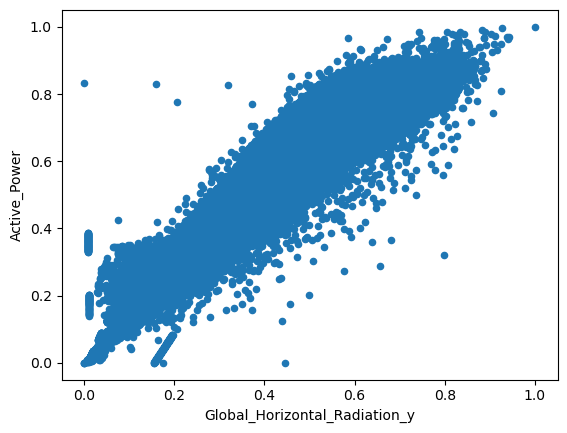

In [41]:
df_dbscan.plot.scatter(x='Global_Horizontal_Radiation_y', y='Active_Power')

##  Etape1:choix du  eps

### 1. Normaliser les données :

In [42]:
data_scaled =df_dbscan.values

In [43]:
data_scaled

array([[0.28117678, 0.25032272],
       [0.29483551, 0.26843179],
       [0.3090476 , 0.28745883],
       ...,
       [0.3634202 , 0.38883635],
       [0.34385894, 0.36934195],
       [0.33130224, 0.35122733]])

### 2. Calculer les distances des k-voisins les plus proches :

In [44]:
from sklearn.neighbors import NearestNeighbors
# Choisir k (par exemple, min_samples = 10)
k = 10
# Calculer les distances des k-voisins les plus proches
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(data_scaled)
distances, indices = neighbors_fit.kneighbors(data_scaled)

In [45]:
distances[0]

array([0.        , 0.00068784, 0.00113143, 0.00159424, 0.00191342,
       0.0024181 , 0.00275469, 0.00292827, 0.00296111, 0.00308229])

### 3. Trouver le point de décollage :

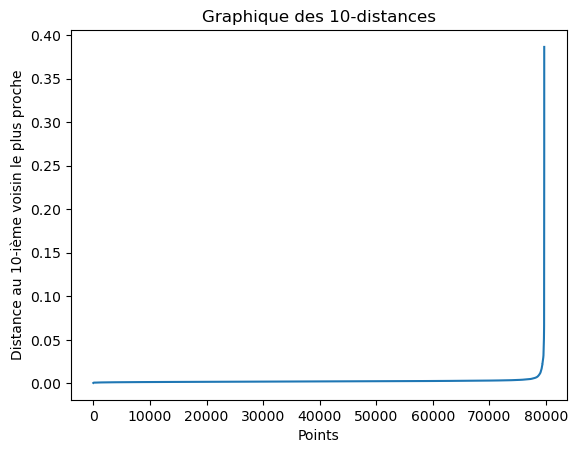

In [46]:
# Tracer le graphique des k-distances
k_distances =np.sort(distances[:, -1])  # Dernière colonne des distances (k-ème voisin)
plt.plot(k_distances)
plt.xlabel('Points')
plt.ylabel('Distance au 10-ième voisin le plus proche')
plt.title('Graphique des 10-distances')
plt.show()

In [48]:
# Ajuster une ligne droite entre le premier et le dernier point
from scipy.spatial.distance import euclidean
k_distances_sorted = np.sort(distances[:, -1])
line_start = [0, k_distances_sorted[0]]
line_end = [len(k_distances_sorted)-1,k_distances_sorted[-1]]
# Calculer la distance de chaque point à la ligne
distances_to_line = []
for i, y in enumerate(k_distances_sorted):
    # Point sur la ligne
    line_point = [(line_end[0]-line_start[0]) * i / (len(k_distances_sorted)-1) + line_start[0],
                  (line_end[1]-line_start[1]) * i / (len(k_distances_sorted)-1) + line_start[1]]
    distances_to_line.append(euclidean([i, y], line_point))
# Trouver le point le plus éloigné de la ligne
index_coudee = np.argmax(distances_to_line)
epsilon = k_distances_sorted[index_coudee]
print("Valeur estimée de epsilon :", epsilon)

Valeur estimée de epsilon : 0.007928246463250974


Valeur estimée de epsilon : 0.007928246463250974


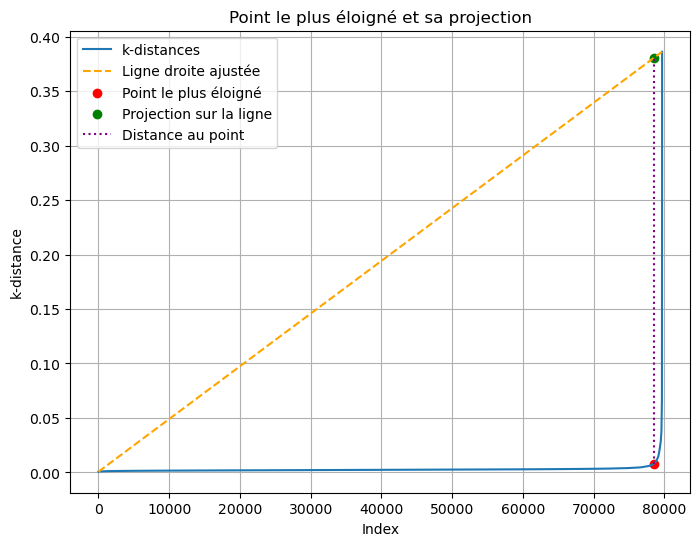

In [49]:
from scipy.spatial.distance import euclidean
import numpy as np
import matplotlib.pyplot as plt
# Définir les points de la droite (premier et dernier point)
line_start = [0, k_distances_sorted[0]]
line_end = [len(k_distances_sorted) - 1, k_distances_sorted[-1]]

# Calculer la distance de chaque point à la ligne
distances_to_line = []
projections = []
for i, y in enumerate(k_distances_sorted):
    # Point sur la ligne
    t = i / (len(k_distances_sorted) - 1)
    line_point = [
        (1 - t) * line_start[0] + t * line_end[0],
        (1 - t) * line_start[1] + t * line_end[1],
    ]
    distances_to_line.append(euclidean([i, y], line_point))
    projections.append(line_point)

# Trouver le point le plus éloigné de la ligne
index_coudee = np.argmax(distances_to_line)
epsilon = k_distances_sorted[index_coudee]
point_coudee = [index_coudee, epsilon]
point_projection = projections[index_coudee]

# Afficher les résultats
print("Valeur estimée de epsilon :", epsilon)

# Tracer les données
plt.figure(figsize=(8, 6))
plt.plot(range(len(k_distances_sorted)), k_distances_sorted, label="k-distances", lw=1.5)
plt.plot(
    [line_start[0], line_end[0]], 
    [line_start[1], line_end[1]], 
    label="Ligne droite ajustée", 
    linestyle="--", 
    color="orange",
)
plt.scatter(point_coudee[0], point_coudee[1], color="red", label="Point le plus éloigné")
plt.scatter(
    point_projection[0], 
    point_projection[1], 
    color="green", 
    label="Projection sur la ligne",
)
plt.plot(
    [point_coudee[0], point_projection[0]],
    [point_coudee[1], point_projection[1]],
    color="purple",
    linestyle=":",
    label="Distance au point",
)
plt.legend()
plt.xlabel("Index")
plt.ylabel("k-distance")
plt.title("Point le plus éloigné et sa projection")
plt.grid()
plt.show()


### Application du dbscan

In [50]:
df_dbscan_train=train_data[['Global_Horizontal_Radiation_y','Active_Power']]
df_dbscan_test=test_data[['Global_Horizontal_Radiation_y','Active_Power']]
df_dbscan_validation=validation_data[['Global_Horizontal_Radiation_y','Active_Power']]
dbscan_train=df_dbscan_train.values
dbscan_test=df_dbscan_test.values
dbscan_validation=df_dbscan_validation.values

In [51]:
def two_clusters(dbscan):
    for i in range(len(dbscan)):
        if dbscan[i]>1:
            dbscan[i]=-1
    return dbscan

In [52]:
dbscan_train=two_clusters(DBSCAN( 0.007928246463250974, min_samples=3).fit_predict(dbscan_train))
dbscan_test=two_clusters(DBSCAN( 0.007928246463250974, min_samples=3).fit_predict(dbscan_test))
dbscan_validation=two_clusters(DBSCAN( 0.007928246463250974, min_samples=3).fit_predict(dbscan_validation))

In [53]:
df_dbscan_train.loc[df_dbscan_train['Cluster'] == -1, ['Active_Power', 'Global_Horizontal_Radiation_y']] = np.nan

KeyError: 'Cluster'

In [ ]:
df_dbscan_train_numeric = df_dbscan_train.select_dtypes(include=[np.number])  # Sélection des colonnes numériques

df_dbscan_train[df_dbscan_train_numeric.columns] = df_dbscan_train_numeric.interpolate(method='linear')  # Interpolation linéaire


In [ ]:
df_dbscan_train.isna().sum()

In [ ]:
# Ajouter les résultats de DBSCAN au DataFrame original
def plot_dbscan(dbscan,df_dbscan):
    df_dbscan['Cluster'] = dbscan  # dbscan contient les étiquettes du clustering
    # Séparer les valeurs aberrantes et les points des clusters
    outliers = df_dbscan[df_dbscan['Cluster'] == -1]
    clusters = df_dbscan[df_dbscan['Cluster'] != -1]

    # Créer le scatter plot
    plt.figure(figsize=(10, 6))

    # Points des clusters (non-aberrants)
    plt.scatter(clusters['Global_Horizontal_Radiation_y'], clusters['Active_Power'],
                c='green', cmap='viridis', s=10, label="Clusters")

    # Points aberrants
    plt.scatter(outliers['Global_Horizontal_Radiation_y'], outliers['Active_Power'],
                c='red', s=10, label="Valeurs aberrantes")

    # Ajouter des labels et un titre
    plt.title("Visualisation des valeurs aberrantes avec DBSCAN")
    plt.xlabel("Global Horizontal Radiation (y)")
    plt.ylabel("Active Power")
    plt.legend()
    plt.show()

In [ ]:
df_dbscan_train.plot.scatter(x='Global_Horizontal_Radiation_y', y='Active_Power')

In [ ]:
plot_dbscan(dbscan_train,df_dbscan_train)

In [ ]:
df_dbscan_test.plot.scatter(x='Global_Horizontal_Radiation_y', y='Active_Power')

In [ ]:
plot_dbscan(dbscan_test,df_dbscan_test)

In [ ]:
plot_dbscan(dbscan_validation,df_dbscan_validation)
df_dbscan_validation.plot.scatter(x='Global_Horizontal_Radiation_y', y='Active_Power')

# Univarié

## train_data

In [ ]:

# Création du boxplot
sns.boxplot(data=train_data[['Active_Power']])
plt.show()

In [ ]:
sns.boxplot(data=train_data[['Global_Horizontal_Radiation_y']])
plt.show()

## test data

In [ ]:
sns.boxplot(data=test_data[['Active_Power']])
plt.show()

In [ ]:
sns.boxplot(data=test_data[['Global_Horizontal_Radiation_y']])


## Validation_data

In [ ]:
sns.boxplot(data=validation_data[['Active_Power']])
plt.show()

In [ ]:
sns.boxplot(data=validation_data[['Global_Horizontal_Radiation_y']])
plt.show()

# df to array

In [54]:
def df_to_array(df):
    sequence_length = 109
    # Transformer les données en un tableau de la forme (samples, sequence_length, features)
    data_array = df[columns_to_normalize].values  # Extraire les valeurs comme NumPy
    n_samples = len(data_array) - sequence_length + 1

    # Créer l'array final
    result = np.array([
        data_array[i:i+sequence_length]
        for i in range(n_samples)
    ])
    return result

In [55]:
import numpy as np

def df_to_array(df, columns_to_normalize, sequence_length=109):
    # Assurer que la première colonne est celle des timestamps
    # Exclure la première colonne des timestamps, qui ne fait pas partie des features
    data_array = df[columns_to_normalize].values  # Extraire les valeurs comme NumPy
    
    # Calculer le nombre d'années à partir du nombre total de lignes
    n_samples = len(df) // sequence_length  # Nombre d'échantillons, soit le nombre de jours
    
    # Redimensionner les données en (n_samples, sequence_length, n_features)
    reshaped_array = data_array[:n_samples * sequence_length].reshape(n_samples, sequence_length, -1)

    # Exclure la première colonne des timestamps, qui ne fait pas partie des features
    result = reshaped_array[:, :, :]  # Exclure la première colonne
    return result

In [56]:
columns_to_normalize

['Active_Power',
 'Weather_Temperature_Celsius_y',
 'Weather_Relative_Humidity_y',
 'Global_Horizontal_Radiation_y',
 'Weather_Daily_Rainfall_y']

In [57]:
array_train=df_to_array(train_data,columns_to_normalize, sequence_length=109)

In [58]:
array_test=df_to_array(test_data,columns_to_normalize, sequence_length=109)

In [59]:
array_validation=df_to_array(validation_data,columns_to_normalize, sequence_length=109)

In [60]:
print("shape:",np.shape(array_train))

shape: (731, 109, 5)


In [61]:
print("shape:",np.shape(array_test))

shape: (365, 109, 5)


In [62]:
print("shape:",np.shape(array_validation))

shape: (365, 109, 5)


In [65]:
len(array_train[0,:,0])

109

In [72]:
train_data

,Timestamp,Active_Power,Weather_Temperature_Celsius_y,Weather_Relative_Humidity_y,Global_Horizontal_Radiation_y,Weather_Daily_Rainfall_y
0,2019-01-01 08:00:00,0.250323,0.771094,0.175182,0.281177,0.0
1,2019-01-01 08:05:00,0.268432,0.774902,0.172906,0.294836,0.0
2,2019-01-01 08:10:00,0.287459,0.778892,0.168922,0.309048,0.0
3,2019-01-01 08:15:00,0.305657,0.776552,0.168517,0.321180,0.0
4,2019-01-01 08:20:00,0.325290,0.777133,0.165870,0.335278,0.0
...,...,...,...,...,...,...
79674,2020-12-31 16:40:00,0.425477,0.771947,0.101844,0.391093,0.0
79675,2020-12-31 16:45:00,0.406767,0.771218,0.100983,0.377056,0.0
79676,2020-12-31 16:50:00,0.388836,0.768811,0.102035,0.363420,0.0
79677,2020-12-31 16:55:00,0.369342,0.770279,0.103139,0.343859,0.0


In [71]:
array_train

array([[[0.25032272, 0.77109386, 0.17518233, 0.28117678, 0.        ],
        [0.26843179, 0.77490209, 0.17290612, 0.29483551, 0.        ],
        [0.28745883, 0.778892  , 0.16892229, 0.3090476 , 0.        ],
        ...,
        [0.36641557, 0.95061866, 0.07530731, 0.34615556, 0.        ],
        [0.34828424, 0.94894433, 0.07486993, 0.33426938, 0.        ],
        [0.33339084, 0.93846889, 0.07718997, 0.32250783, 0.        ]],

       [[0.2487538 , 0.76958774, 0.10733973, 0.28089379, 0.        ],
        [0.26802007, 0.76926232, 0.10639036, 0.29534473, 0.        ],
        [0.28653531, 0.77177676, 0.10561372, 0.30935555, 0.        ],
        ...,
        [0.36302739, 0.9614353 , 0.06566073, 0.34673907, 0.        ],
        [0.3499366 , 0.96817043, 0.06521604, 0.33954724, 0.        ],
        [0.33706825, 0.95831354, 0.06749478, 0.33247985, 0.        ]],

       [[0.24487048, 0.82118116, 0.08907842, 0.28222762, 0.        ],
        [0.26381968, 0.81988864, 0.08818546, 0.29694688, 0. 